# In the beginning... there were imports and global parameters

In [1]:
from jax import numpy as jnp, random, vmap, value_and_grad
from jax.lax import scan
import networkx
import matplotlib.pyplot as plt
import optax

import qujax

In [2]:
n_nodes = 6
degree = 3
n_qubits = n_nodes - 1
circuit_depth = 2
init_rad = 0.001 / jnp.pi
stepsize = 1e-3
n_shots = 100
n_steps = 1000
random_key = random.PRNGKey(0)

In [3]:
graph_key, weights_key, init_key, train_key = random.split(random_key, 4)

# Then came the problem specification

In this case the maximal cutting a degree three, regular graph with six nodes and randomly weighted edges. Note that this corresponds to a five qubit maxcut problem since the first node can be labelled as zero by default.

Recall that a maxcut problem is the problem of finding the _binary labelling of nodes such that the sum of edge weights for edges with differing nodes_ is maximised.

In [4]:
nx_graph = networkx.generators.random_graphs.random_regular_graph(degree, n_nodes, seed=int(graph_key[-1]))
edge_inds = jnp.array(nx_graph.edges)
weights = random.uniform(weights_key, shape=(len(edge_inds),))

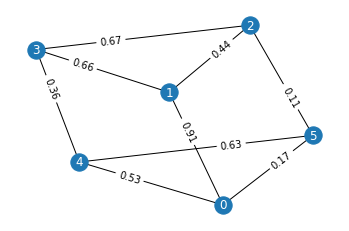

In [5]:
pos = networkx.spring_layout(nx_graph)
networkx.draw_networkx_nodes(nx_graph, pos)
networkx.draw_networkx_labels(nx_graph, pos, font_color='white')
networkx.draw_networkx_edges(nx_graph, pos)
networkx.draw_networkx_edge_labels(nx_graph, pos, label_pos=0.35,
                                   edge_labels={tuple(e):f'{w:.2f}' for e, w in zip(edge_inds.tolist(), weights)})
plt.axis('off');

The cost function can then be defined directly on a bitstring

In [6]:
def cost_of_bitstring(z):
    z = jnp.append(0, z)

    def get_z_edge_weight(ei, w):
        i, j = ei
        return jnp.where(z[i] != z[j], w, 0.)

    return -vmap(get_z_edge_weight)(edge_inds, weights).sum()

# Then comes the quantum circuit

The quantum circuit is comprised of a series of gates, some of which are entangling, some of which are parameterised...

In [7]:
def get_circuit(n_qubits, depth):
    
    n_params = 2 * n_qubits * (depth + 1)
    
    
    gates = ['H'] * n_qubits + ['Rx'] * n_qubits + ['Rz'] * n_qubits
    qubit_inds = [[i] for i in range(n_qubits)] * 3
    param_inds = [[]] * n_qubits + [[i] for i in range(n_qubits * 2)]
    
    k = 2 * n_qubits

    for _ in range(depth):
        for i in range(0, n_qubits - 1):
            gates.append('CZ')
            qubit_inds.append([i, i + 1])
            param_inds.append([])
        gates.append('CZ')
        qubit_inds.append([n_qubits-1, 0])
        param_inds.append([])
        for i in range(n_qubits):
            gates.append('Rx')
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
        for i in range(n_qubits):
            gates.append('Ry')
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
    return gates, qubit_inds, param_inds, n_params

In [8]:
gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, circuit_depth)

In [9]:
qujax.print_circuit(gates, qubit_inds, param_inds, gate_ind_max=30);

q0: -----H-----Rx[0]---Rz[5]-----◯-------------------------------CZ----Rx[10]--Ry[15]----◯---
                                 |                               |                       |   
q1: -----H-----Rx[1]---Rz[6]-----CZ------◯-----------------------|-----Rx[11]--Ry[16]----CZ--
                                         |                       |                           
q2: -----H-----Rx[2]---Rz[7]-------------CZ------◯---------------|-----Rx[12]--Ry[17]--------
                                                 |               |                           
q3: -----H-----Rx[3]---Rz[8]---------------------CZ------◯-------|-----Rx[13]--Ry[18]--------
                                                         |       |                           
q4: -----H-----Rx[4]---Rz[9]-----------------------------CZ------◯-----Rx[14]--Ry[19]--------


Passes the eye test 👍

# Now to invoke qujax

Let's generate the parameters -> statetensor function.

Always be aware that we still have convention where parameters are specified as multiples of $\pi$ - that is in [0,2].

In [10]:
param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)

In the [other notebooks](https://github.com/CQCL/qujax/tree/main/examples), we use automatic differentiaion via JAX's `value_and_grad` function. In this notebook, we will use more realistic stochastic gradients via the parameter shift rule
$$
    \nabla_{\theta_k} C(\theta) = \frac12 \left( C\left(\theta + \frac{\pi}{2}e_k\right) -  C\left(\theta - \frac{\pi}{2} e_k \right) \right),
$$

where the parameters are the rotations of single-qubit gates $U_k(\theta_k) = e^{-i\theta_k V_k / 2}$ and $e_k$ is the $k$th unit vector. For our maxcut problem, the cost function is $C(\theta) = \mathbb{E}_{p(z\mid \theta)}[f(x)]$, where $p(z\mid \theta)$ is the probability of the quantum circuit sampling bitstring $z$ given parameters $\theta$ and $f(z)$ is the maxcut `cost_of_bitstring` function above. In practice, the cost function $C(\theta)$ cannot be evaluated exactly and is instead approximated by Monte Carlo - as we shall simulate here.

In [11]:
def param_to_sampled_cost_and_grad(param, random_key):

    random_keys = random.split(random_key, 2 * param.size + 1)
    cost_key = random_keys[0]
    grad_keys = random_keys[1:]

    st = param_to_st(param)
    sample_bitstrings = qujax.sample_bitstrings(cost_key, st, n_samps=n_shots)
    sampled_cost = vmap(cost_of_bitstring)(sample_bitstrings).mean()

    def sample_grad_k(k, random_key_plus, random_key_minus):
        param_plus = param.at[k].set(param[k] + 0.5)
        st_plus = param_to_st(param_plus)
        sample_bitstrings_plus = qujax.sample_bitstrings(random_key_plus, st_plus, n_samps=n_shots)

        param_minus = param.at[k].set(param[k] - 0.5)
        st_minus = param_to_st(param_minus)
        sample_bitstrings_minus = qujax.sample_bitstrings(random_key_minus, st_minus, n_samps=n_shots)

        return (vmap(cost_of_bitstring)(sample_bitstrings_plus).mean() - vmap(cost_of_bitstring)(sample_bitstrings_minus).mean()) / 2

    sampled_grad = vmap(sample_grad_k)(jnp.arange(param.size),
                                       grad_keys[:param.size],
                                       grad_keys[param.size:])
    return sampled_cost, sampled_grad

# Stochastic gradient descent time

We will use [`optax`](https://github.com/deepmind/optax) to run gradient descent with Adam.

In [12]:
optimiser = optax.adam(stepsize)

In [13]:
init_param = random.uniform(init_key, shape=(n_params,), minval=-init_rad, maxval=init_rad)

In [14]:
init_opt_state = optimiser.init(init_param)

In [15]:
def gd_iteration(params_and_opt_state_and_rk, step):
    params, opt_state, rk_in = params_and_opt_state_and_rk
    rk_out, rk_samp = random.split(rk_in)

    cost, grads = param_to_sampled_cost_and_grad(params, rk_samp)

    updates, new_opt_state = optimiser.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return (new_params, new_opt_state, rk_out), (params, cost)

In [16]:
_, (params_path, cost_path) = scan(gd_iteration,
                                   (init_param, init_opt_state, train_key),
                                   jnp.arange(n_steps))

Lets visualise the results

In [17]:
opt_cost = vmap(cost_of_bitstring)(qujax.integers_to_bitstrings(jnp.arange(2 ** n_qubits), n_qubits)).min()

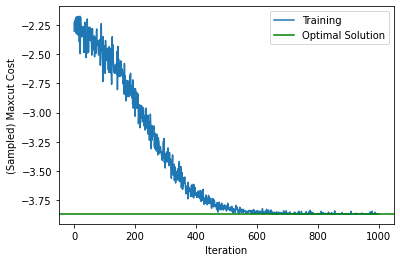

In [18]:
plt.plot(cost_path, label='Training')
plt.axhline(opt_cost, color='green', label='Optimal Solution')
plt.xlabel('Iteration')
plt.ylabel('(Sampled) Maxcut Cost')
plt.legend();